In [265]:
import pyarrow.feather as feather
import numpy as np
import pandas as pd
import os
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()
from collections import Counter

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm,trange 
from pandas.tseries.offsets import Day, YearEnd, YearBegin
from datetime import datetime, timedelta

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.callbacks import EarlyStopping

In [3]:
pd.options.display.max_columns = 10 # 最大显示列数
pd.options.display.max_rows = 10 # 最大显示行数

## read character data

In [50]:
raw_df=feather.read_feather('/Users/shuxianhong/Desktop/Summer Project/chars60_raw_imputed.feather')

In [24]:
raw_df.columns

Index(['gvkey', 'permno', 'sic', 'ret', 'exchcd', 'shrcd', 'adm', 'bm_ia',
       'herf', 'hire', 'me_ia', 'baspread', 'beta', 'ill', 'maxret', 'mom12m',
       'mom1m', 'mom36m', 'mom60m', 'mom6m', 're', 'rvar_capm', 'rvar_ff3',
       'rvar_mean', 'seas1a', 'std_dolvol', 'std_turn', 'zerotrade', 'me',
       'dy', 'turn', 'dolvol', 'abr', 'sue', 'cinvest', 'nincr', 'pscore',
       'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho',
       'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni',
       'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe',
       'rsup', 'sgr', 'sp', 'date', 'ffi49'],
      dtype='object')

In [25]:
raw_tf = raw_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

['adm',
 'bm_ia',
 'mom12m',
 'mom36m',
 'mom60m',
 'mom6m',
 'seas1a',
 'abr',
 'sue',
 'cinvest',
 'nincr',
 'pscore',
 'acc',
 'bm',
 'agr',
 'alm',
 'ato',
 'cashdebt',
 'chcsho',
 'chpm',
 'chtx',
 'gma',
 'grltnoa',
 'lgr',
 'ni',
 'noa',
 'op',
 'pctacc',
 'rna',
 'roa',
 'roe',
 'rsup',
 'sgr']

In [26]:
raw_df['year'] = raw_df['date'].dt.year
raw_df = raw_df[raw_df['year'] >= 1972]
raw_df = raw_df.drop(['year'], axis=1)

In [27]:
raw_tf = raw_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

no missing value!

In [28]:
raw_df

,gvkey,permno,sic,ret,exchcd,...,rsup,sgr,sp,date,ffi49
136,1010,10006,3743,0.004854,1.0,...,0.000047,0.042217,0.001158,1972-01-31,25
137,1010,10006,3743,-0.007729,1.0,...,0.000047,0.042217,0.001152,1972-02-29,25
138,1010,10006,3743,-0.068966,1.0,...,0.000048,0.042217,0.001175,1972-03-31,25
139,1010,10006,3743,-0.068783,1.0,...,0.000051,0.042217,0.001262,1972-04-30,25
140,1010,10006,3743,0.025000,1.0,...,-0.000004,-0.003038,0.001351,1972-05-31,25
...,...,...,...,...,...,...,...,...,...,...,...
551140,260778,90272,6324,-0.057476,1.0,...,0.000146,0.272945,0.001559,2019-08-31,46
551141,260778,90272,6324,-0.042735,1.0,...,0.000155,0.272945,0.001654,2019-09-30,46
551142,260778,90272,6324,0.144423,1.0,...,0.000162,0.272945,0.001728,2019-10-31,46
551143,260778,90272,6324,0.085873,1.0,...,0.000159,0.380853,0.001668,2019-11-30,46


## read macro data

In [29]:
macro_df = pd.read_csv('/Users/shuxianhong/Desktop/Summer Project/Macro.csv')
macro_df = macro_df[macro_df['yyyymm']>=197201]

In [30]:
macro_df

,yyyymm,b/m,tbl,ntis,svar,d/p,e/p,dfy,tms
1212,197201,0.635357,0.0338,0.033075,0.000494,1.529644,1.258123,0.0104,0.0268
1213,197202,0.617586,0.0320,0.033030,0.000284,1.540497,1.266209,0.0096,0.0282
1214,197203,0.645902,0.0373,0.031723,0.000545,1.543056,1.266019,0.0100,0.0240
1215,197204,0.636784,0.0371,0.032492,0.000383,1.544956,1.263950,0.0094,0.0244
1216,197205,0.632442,0.0369,0.030657,0.000769,1.552395,1.267456,0.0093,0.0228
...,...,...,...,...,...,...,...,...,...
1795,202008,0.235975,0.0010,-0.008504,0.000743,1.772309,1.550421,0.0102,0.0055
1796,202009,0.241482,0.0011,-0.005698,0.004907,1.756971,1.534527,0.0105,0.0057
1797,202010,0.253146,0.0010,-0.001895,0.003661,1.746197,1.528413,0.0109,0.0069
1798,202011,0.226352,0.0009,-0.005262,0.002492,1.791974,1.578931,0.0100,0.0078


## merge macro & char

In [31]:
raw_df['yyyymm'] = raw_df['date'].dt.strftime('%Y%m').apply(int)
total_df = pd.merge(raw_df, macro_df, how='inner',on='yyyymm')
total_df.drop(columns='yyyymm',inplace=True)
total_df

,gvkey,permno,sic,ret,exchcd,...,svar,d/p,e/p,dfy,tms
0,1010,10006,3743,0.004854,1.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
1,1040,15763,3949,0.111399,1.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
2,1043,18980,5040,0.080000,1.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
3,1045,21020,4512,0.042945,1.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
4,1070,21549,3714,0.191489,2.0,...,0.000494,1.529644,1.258123,0.0104,0.0268
...,...,...,...,...,...,...,...,...,...,...,...
462751,188255,12981,2430,0.048165,1.0,...,0.000746,1.722817,1.265919,0.0076,0.0371
462752,189491,13035,3561,0.001157,1.0,...,0.000746,1.722817,1.265919,0.0076,0.0371
462753,199356,13168,7370,-0.062160,3.0,...,0.000746,1.722817,1.265919,0.0076,0.0371
462754,260774,90199,6500,0.084983,1.0,...,0.000746,1.722817,1.265919,0.0076,0.0371


In [32]:
raw_tf = total_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

In [33]:
total_df.permno.nunique()

1571

## information variable

- stock indicator: gvkey, permno
- time: datadate, date, year ('datadate' is the available time for data and 'date' is the date of return)
- industry: sic, ffi49
- exchange info: exchcd, shrcd
- return: ret: the dividend adjusted return (we also provide original return and return without dividend, you can keep them by modifing impute_rank_output_bchmk.py)
- market equity: me/rank_me


In [34]:
# need to turn some variables to dummy variables
def get_dummy_col(target_df, col_names):
    """turn the cols into multiple cols containing dummy variables, then drop the original columns

    Args:
        target_df (pandas dataframe): target dataframe
        col_names (list): list of columns that need to be turned into dummy variables
    """
    for col in col_names:        
        tmp_dummies = pd.get_dummies(target_df[col]).rename(columns=lambda x: f'{col}_' + str(x))
        target_df = pd.concat([target_df, tmp_dummies], axis=1)
        target_df.drop(col, inplace=True, axis = 1)
    return target_df 
dummy_col_list = ['ffi49', 'shrcd', 'exchcd']
total_df = get_dummy_col(total_df, dummy_col_list)

In [ ]:
total_df.set_index('date', inplace=True)
total_df.sort_values(by=['permno','date'])
total_df

<AxesSubplot:xlabel='date'>

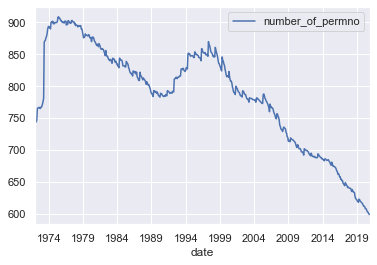

In [56]:
each_month_permno_num = pd.DataFrame(Counter(total_df.reset_index().date).items(), columns=['date', 'number_of_permno'])
each_month_permno_num.plot(x='date', y='number_of_permno')

In [37]:
# set character features list
features_list = total_df.columns.tolist()
remove_list = {'gvkey', 'permno', 'ret'}
features_list = [ele for ele in features_list if ele not in remove_list]
len(features_list)

123

## check distribution and correlation 

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_1027/1472815176.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  total_df[features_list[:70]].hist(layout=(28, 6), bins=np.linspace(-1,1,50), ax=ax);


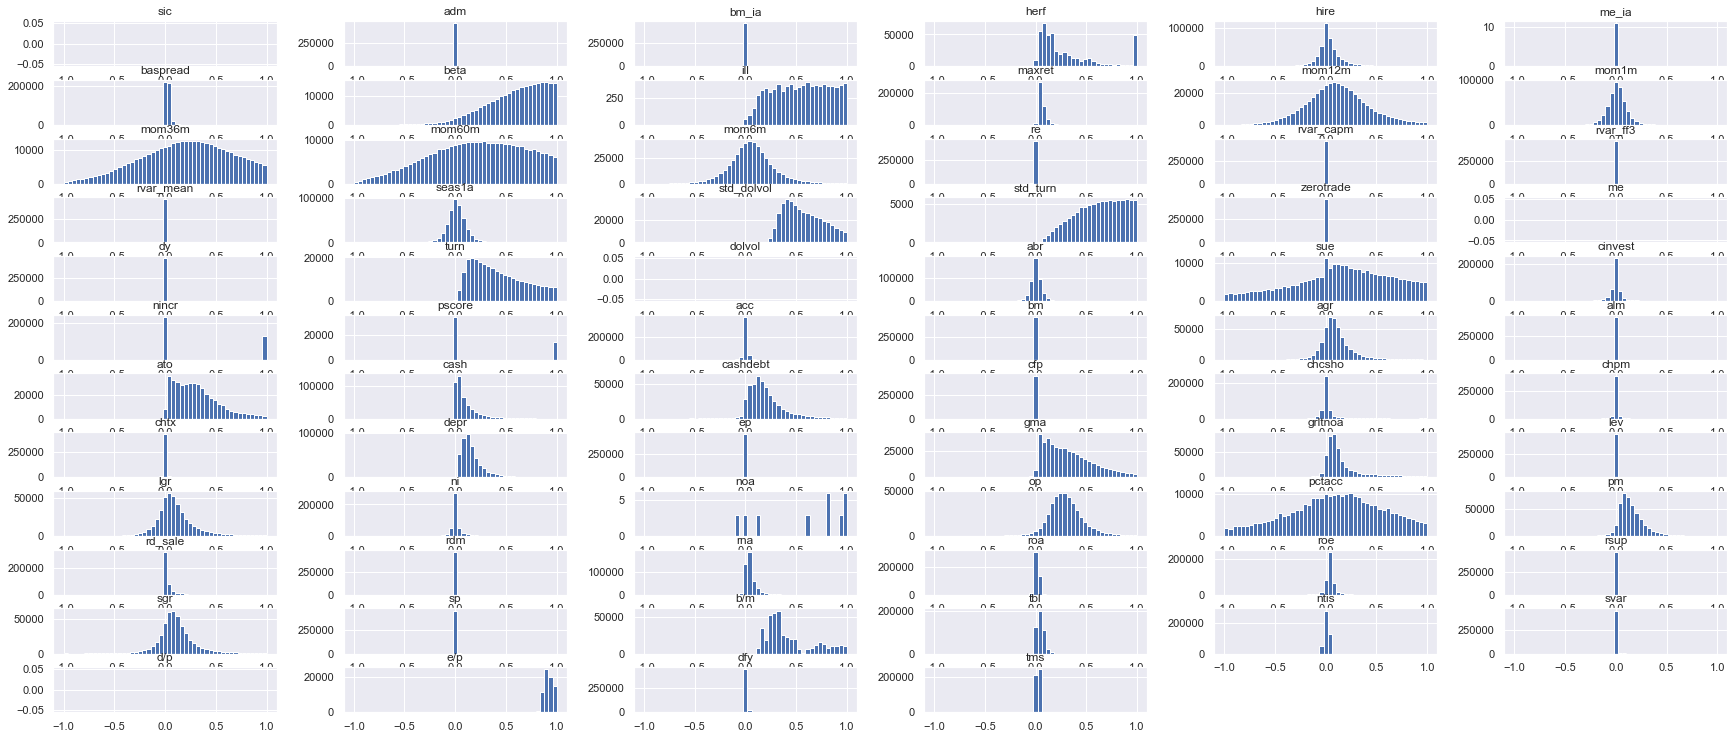

In [44]:
fig, ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(30)
total_df[features_list[:70]].hist(layout=(28, 6), bins=np.linspace(-1,1,50), ax=ax);

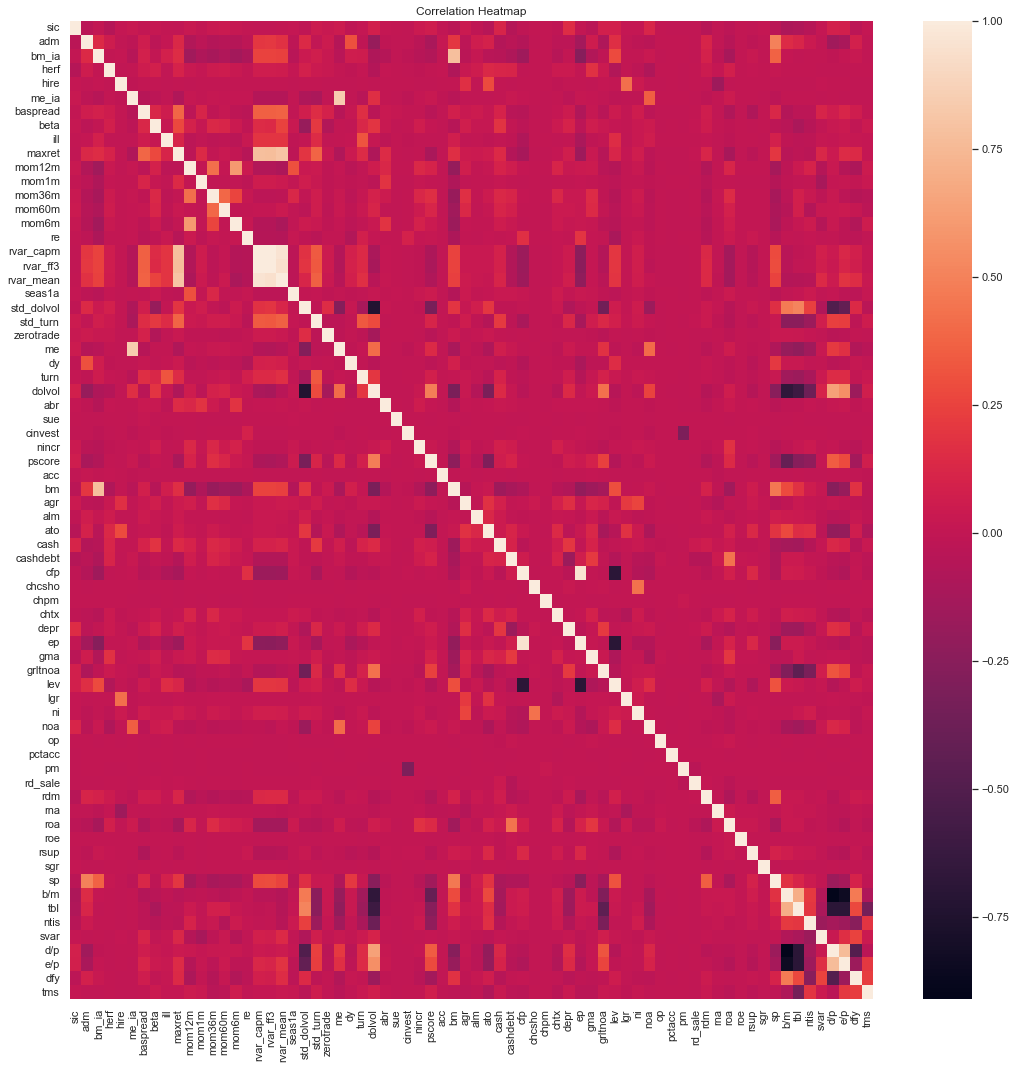

<Figure size 432x288 with 0 Axes>

In [43]:
plt.figure(figsize = (18,18))
sns.heatmap(data=total_df[features_list[:70]].corr())
plt.title('Correlation Heatmap')
plt.show()
plt.gcf().clear()

## normalization 

In [68]:
scaler = StandardScaler()
scaler.fit(total_df[features_list])
normalized = scaler.transform(total_df[features_list])
normalized_data = pd.DataFrame(normalized , columns=features_list, index=total_df.index)

print("The shape of normalised numerical data : " , normalized.shape)
normalized_data

The shape of normalised numerical data :  (462756, 123)


,sic,adm,bm_ia,herf,hire,...,shrcd_10.0,shrcd_11.0,exchcd_1.0,exchcd_2.0,exchcd_3.0
date,,,,,,,,,,,
1972-01-31,-0.369620,-0.266273,0.060930,1.331469,-0.018029,...,3.179212,-3.179212,0.521844,-0.153297,-0.486013
1972-01-31,0.284891,0.014889,-0.129580,-0.971418,-0.008339,...,-0.314543,0.314543,0.521844,-0.153297,-0.486013
1972-01-31,-0.221094,0.021566,0.520359,-0.833250,-0.013473,...,3.179212,-3.179212,0.521844,-0.153297,-0.486013
1972-01-31,-1.767314,0.014889,0.035823,0.990053,0.011529,...,-0.314543,0.314543,0.521844,-0.153297,-0.486013
1972-01-31,0.378551,0.014889,0.352443,-0.458297,-0.032889,...,3.179212,-3.179212,0.521844,-0.153297,-0.486013
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,-0.232732,0.070075,0.111282,0.468458,-0.030525,...,-0.314543,0.314543,-1.916281,-0.153297,2.057560
2020-12-31,-1.867624,-0.276036,0.025799,2.258603,0.016573,...,-0.314543,0.314543,0.521844,-0.153297,-0.486013
2020-12-31,-0.769753,-0.127914,0.005229,2.258603,-0.015158,...,-0.314543,0.314543,0.521844,-0.153297,-0.486013


In [69]:
normalized_data.describe()

,sic,adm,bm_ia,herf,hire,...,shrcd_10.0,shrcd_11.0,exchcd_1.0,exchcd_2.0,exchcd_3.0
count,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,...,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05,4.627560e+05
mean,-5.487722e-14,1.463961e-15,-2.071346e-17,-1.913657e-15,-1.786435e-15,...,6.600916e-13,-6.600917e-13,-2.244325e-13,5.328770e-13,5.818449e-13
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.388573e+00,-3.202886e-01,-1.567056e+01,-1.039444e+00,-1.028637e-01,...,-3.145434e-01,-3.179212e+00,-1.916281e+00,-1.532965e-01,-4.860126e-01
25%,-8.307148e-01,-2.661362e-01,-2.693524e-01,-7.353735e-01,-1.577029e-02,...,-3.145434e-01,3.145434e-01,5.218442e-01,-1.532965e-01,-4.860126e-01
50%,-3.097661e-01,-1.820625e-01,-4.781521e-02,-4.402527e-01,-1.191368e-02,...,-3.145434e-01,3.145434e-01,5.218442e-01,-1.532965e-01,-4.860126e-01
75%,8.590432e-01,7.905231e-03,1.431363e-01,4.222584e-01,-5.272497e-03,...,-3.145434e-01,3.145434e-01,5.218442e-01,-1.532965e-01,-4.860126e-01
max,3.096351e+00,1.844458e+02,1.688836e+02,2.258603e+00,1.894846e+02,...,3.179212e+00,3.145434e-01,5.218442e-01,6.523305e+00,2.057560e+00


In [77]:
normalized_data.head(2000)

,sic,adm,bm_ia,herf,hire,...,shrcd_10.0,shrcd_11.0,exchcd_1.0,exchcd_2.0,exchcd_3.0
date,,,,,,,,,,,
1972-01-31,-0.369620,-0.266273,0.060930,1.331469,-0.018029,...,3.179212,-3.179212,0.521844,-0.153297,-0.486013
1972-01-31,0.284891,0.014889,-0.129580,-0.971418,-0.008339,...,-0.314543,0.314543,0.521844,-0.153297,-0.486013
1972-01-31,-0.221094,0.021566,0.520359,-0.833250,-0.013473,...,3.179212,-3.179212,0.521844,-0.153297,-0.486013
1972-01-31,-1.767314,0.014889,0.035823,0.990053,0.011529,...,-0.314543,0.314543,0.521844,-0.153297,-0.486013
1972-01-31,0.378551,0.014889,0.352443,-0.458297,-0.032889,...,3.179212,-3.179212,0.521844,-0.153297,-0.486013
...,...,...,...,...,...,...,...,...,...,...,...
1972-03-31,0.277687,-0.057986,0.049987,-0.971418,-0.017404,...,-0.314543,0.314543,0.521844,-0.153297,-0.486013
1972-03-31,3.096351,-0.057986,0.180322,1.042833,-0.021661,...,-0.314543,0.314543,0.521844,-0.153297,-0.486013
1972-03-31,1.158312,0.257870,-0.116499,2.019984,-0.013646,...,3.179212,-3.179212,0.521844,-0.153297,-0.486013


## data split & Neural Network model

In [246]:
X_total = normalized_data
Y_total = pd.DataFrame(total_df['ret'], index=total_df.index)

- total:1972-2020 49 years
- training_length: 32 years; //28
- valid_length: 7 years ; //6
- testing_length: 7 years //6

In [299]:
class model(object):
    '''
    params:
        chardf: character feature dataframe, set date as index and 123 feature columns
        retdf: true return data, set date as index 
        first_train_start_date:初次训练时，训练集的开始日期。
        last_train_start_date:最后一次训练时，训练集的开始日期。
        train_period: 28 year
        valid_period： 6 year
        test_period: 6 year 
        freq: expanding frequency，默认为'y'，每个年滚动一次，总共滚动十次
    '''
    
    def __init__(self,chardf,retdf,first_train_start_date,last_train_start_date, train_period, valid_period, test_period, freq):
        self.chardf = chardf
        self.retdf = retdf
        self.first_train_start_date = first_train_start_date 
        self.last_train_start_date = last_train_start_date
        self.train_period = train_period
        self.valid_period = valid_period
        self.test_period = test_period
        self.freq = freq 
           
    def NN1(self): 
        '''
        single hidden layer of 32 neurons
        '''
        model = Sequential()        
        model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1(10e-5)))
        model.add(Dense(1, activation='relu'))
        
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, loss="mse")
        
        return model     
    
    def NN2(self):  
        '''
        two hidden layers with 32, 16, neurons
        '''
        model = Sequential()        
        model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1(10e-5)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(1, activation='relu'))
        
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, loss="mse")
        
        return model        
    
    def NN3(self): 
        '''
        three hidden layers with 32, 16, 8 neurons
        '''
        model = Sequential()        
        model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1(10e-5)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='relu'))
        
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, loss="mse")
        
        return model
    
    def NN4(self): 
        '''
        four hidden layers with 32, 16, 8,4 neurons
        '''
        model = Sequential()        
        model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l1(10e-5)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(4, activation='relu'))
        model.add(Dense(1, activation='relu'))
        
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, loss="mse")
        
        return model
    
    def NN5(self):   
        '''
        five hidden layers with 32, 16, 8, 4, 2 neurons
        '''
        model = Sequential()        
        model.add(Dense(32, activation='relu',kernel_regularizer=regularizers.l1(10e-5)))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(4, activation='relu'))
        model.add(Dense(2, activation='relu'))
        model.add(Dense(1, activation='relu'))
        
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, loss="mse")
                
        return model
    
    def predict_ret(self):
        train_start_list = pd.date_range(self.first_train_start_date,self.last_train_start_date,freq=self.freq)
        preddf = pd.DataFrame()
        
        for start_date in tqdm(train_start_list):
            #start_date = a[0] # test
            end_date = start_date + self.train_period * YearEnd()
            valid_date = end_date + self.valid_period * YearEnd() 
            test_date = valid_date + self.test_period * YearEnd()

            # training set
            train_x = self.chardf.loc[start_date:end_date] # 28年，逐年滚动
            train_y = self.retdf.loc[start_date:end_date] 

            # validation set
            valid_x = self.chardf.loc[end_date + timedelta(days=1):valid_date] #每个training period后的6年
            valid_y = self.retdf.loc[end_date + timedelta(days=1):valid_date]
            
            # testing set
            test_x = self.chardf.loc[valid_date + timedelta(days=1):test_date] #每个validation period后的6年
            test_y = self.retdf.loc[valid_date + timedelta(days=1):test_date]
            
            # temporary prediction dataframe
            temp_preddf = pd.DataFrame() 
            temp_preddf['real_y'] = test_y.iloc[:,0]
            
            callback = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
            
            # NN1
            regr_NN1 = self.NN1()
            regr_NN1.fit(train_x, train_y, epochs=100,
                         validation_data=(valid_x, valid_y), 
                         callbacks=callback, 
                         batch_size=1000)
            predict_yNN1 = regr_NN1.predict(test_x)
            temp_preddf['NN1_y'] = predict_yNN1

            # NN2
            regr_NN2 = self.NN2()
            regr_NN2.fit(train_x, train_y, epochs=100,
                         validation_data=(valid_x, valid_y), 
                         callbacks=callback, 
                         batch_size=1000)
            predict_yNN2 = regr_NN2.predict(test_x)
            temp_preddf['NN2_y'] = predict_yNN2

            # NN3
            regr_NN3 = self.NN3()
            regr_NN3.fit(train_x, train_y, epochs=100,
                         validation_data=(valid_x, valid_y), 
                         callbacks=callback, 
                         batch_size=1000)
            predict_yNN3 = regr_NN3.predict(test_x)
            temp_preddf['NN3_y'] = predict_yNN3

            # NN4 
            regr_NN4 = self.NN4()
            regr_NN4.fit(train_x, train_y, epochs=100,
                         validation_data=(valid_x, valid_y), 
                         callbacks=callback, 
                         batch_size=1000)
            predict_yNN4 = regr_NN4.predict(test_x)
            temp_preddf['NN4_y'] = predict_yNN4

            # NN5
            regr_NN5 = self.NN5()
            regr_NN5.fit(train_x, train_y, epochs=100,
                         validation_data=(valid_x, valid_y), 
                         callbacks=callback, 
                         batch_size=1000)
            predict_yNN5 = regr_NN5.predict(test_x)
            temp_preddf['NN5_y'] = predict_yNN5
            
            # append temporary predition to final prediction dataframe
            preddf = preddf.append(temp_preddf)
            
        return preddf
    
    def cal_oos(self):
        preddf = self.predict_ret()
        
        denominator = (preddf['real_y'] ** 2).sum()
        numerator = preddf.apply(lambda x: preddf['real_y'] - x).iloc[:,1:]
        numerator = (numerator ** 2).sum()
        
        roos = 1 - numerator / denominator
        roos.index = roos.index.str.rstrip('_y')
        fig,ax = plt.subplots(figsize = (16,12))
        plt.title('Out-of-sample R2', fontsize = 20)
        ax.bar(x = roos.index, height = roos)
        plt.show()
        return roos

In [290]:
basic_2_factors = model(X_total, Y_total, first_train_start_date='19720101', last_train_start_date='19810101', train_period = 28, valid_period = 6, test_period = 6, freq='AS-JAN')



In [291]:
y = basic_2_factors.predict_ret()

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epoch 1/100
283/283 [==============================] - 1s 3ms/step - loss: 0.1875 - val_loss: 0.0776
Epoch 2/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0520 - val_loss: 0.0628
Epoch 3/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0380 - val_loss: 0.0558
Epoch 4/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0329 - val_loss: 0.0485
Epoch 5/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0428
Epoch 6/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0381
Epoch 7/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0233 - val_loss: 0.0335
Epoch 8/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0212 - val_loss: 0.0301
Epoch 9/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0194 - val_loss: 0.0273
Epoch 10/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0180 - val_lo

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_1027/1904827923.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  preddf = preddf.append(temp_preddf)
 10%|████▍                                       | 1/10 [01:15<11:19, 75.51s/it]

Epoch 1/100
284/284 [==============================] - 1s 2ms/step - loss: 0.1635 - val_loss: 0.1086
Epoch 2/100
284/284 [==============================] - 0s 1ms/step - loss: 0.0441 - val_loss: 0.0876
Epoch 3/100
284/284 [==============================] - 0s 1ms/step - loss: 0.0393 - val_loss: 0.0741
Epoch 4/100
284/284 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0639
Epoch 5/100
284/284 [==============================] - 0s 1ms/step - loss: 0.0328 - val_loss: 0.0537
Epoch 6/100
284/284 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0466
Epoch 7/100
284/284 [==============================] - 0s 1ms/step - loss: 0.0253 - val_loss: 0.0407
Epoch 8/100
284/284 [==============================] - 0s 1ms/step - loss: 0.0228 - val_loss: 0.0347
Epoch 9/100
284/284 [==============================] - 0s 1ms/step - loss: 0.0208 - val_loss: 0.0292
Epoch 10/100
284/284 [==============================] - 0s 1ms/step - loss: 0.0192 - val_lo

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_1027/1904827923.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  preddf = preddf.append(temp_preddf)
 20%|████████▊                                   | 2/10 [02:18<09:04, 68.01s/it]

Epoch 1/100
283/283 [==============================] - 1s 2ms/step - loss: 0.0761 - val_loss: 0.0515
Epoch 2/100
283/283 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0409
Epoch 3/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.0328
Epoch 4/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0240 - val_loss: 0.0270
Epoch 5/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0206 - val_loss: 0.0216
Epoch 6/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0185 - val_loss: 0.0180
Epoch 7/100
283/283 [==============================] - 0s 2ms/step - loss: 0.0171 - val_loss: 0.0153
Epoch 8/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0161 - val_loss: 0.0136
Epoch 9/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0155 - val_loss: 0.0131
Epoch 10/100
283/283 [==============================] - 0s 1ms/step - loss: 0.0151 - val_lo

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_1027/1904827923.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  preddf = preddf.append(temp_preddf)
 30%|█████████████▏                              | 3/10 [04:07<10:08, 86.88s/it]

Epoch 1/100
282/282 [==============================] - 1s 2ms/step - loss: 0.0553 - val_loss: 0.0372
Epoch 2/100
282/282 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.0259
Epoch 3/100
282/282 [==============================] - 0s 1ms/step - loss: 0.0237 - val_loss: 0.0193
Epoch 4/100
282/282 [==============================] - 0s 1ms/step - loss: 0.0195 - val_loss: 0.0159
Epoch 5/100
282/282 [==============================] - 0s 2ms/step - loss: 0.0171 - val_loss: 0.0140
Epoch 6/100
282/282 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0130
Epoch 7/100
282/282 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0124
Epoch 8/100
282/282 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 0.0120
Epoch 9/100
282/282 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 10/100
282/282 [==============================] - 0s 2ms/step - loss: 0.0142 - val_lo

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_1027/1904827923.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  preddf = preddf.append(temp_preddf)
 40%|█████████████████▌                          | 4/10 [05:38<08:51, 88.54s/it]

Epoch 1/100
281/281 [==============================] - 1s 2ms/step - loss: 0.2495 - val_loss: 0.1605
Epoch 2/100
281/281 [==============================] - 0s 1ms/step - loss: 0.0520 - val_loss: 0.1050
Epoch 3/100
281/281 [==============================] - 0s 1ms/step - loss: 0.0430 - val_loss: 0.0761
Epoch 4/100
281/281 [==============================] - 0s 1ms/step - loss: 0.0388 - val_loss: 0.0609
Epoch 5/100
281/281 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0504
Epoch 6/100
281/281 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.0417
Epoch 7/100
281/281 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0356
Epoch 8/100
281/281 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.0326
Epoch 9/100
281/281 [==============================] - 0s 1ms/step - loss: 0.0232 - val_loss: 0.0292
Epoch 10/100
281/281 [==============================] - 0s 1ms/step - loss: 0.0213 - val_lo

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_1027/1904827923.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  preddf = preddf.append(temp_preddf)
 50%|██████████████████████                      | 5/10 [07:12<07:31, 90.28s/it]

Epoch 1/100
279/279 [==============================] - 1s 2ms/step - loss: 0.0717 - val_loss: 0.0422
Epoch 2/100
279/279 [==============================] - 0s 1ms/step - loss: 0.0356 - val_loss: 0.0334
Epoch 3/100
279/279 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0270
Epoch 4/100
279/279 [==============================] - 0s 1ms/step - loss: 0.0229 - val_loss: 0.0227
Epoch 5/100
279/279 [==============================] - 0s 1ms/step - loss: 0.0196 - val_loss: 0.0200
Epoch 6/100
279/279 [==============================] - 0s 1ms/step - loss: 0.0174 - val_loss: 0.0181
Epoch 7/100
279/279 [==============================] - 0s 1ms/step - loss: 0.0161 - val_loss: 0.0171
Epoch 8/100
279/279 [==============================] - 0s 1ms/step - loss: 0.0158 - val_loss: 0.0189
Epoch 9/100
279/279 [==============================] - 0s 1ms/step - loss: 0.0151 - val_loss: 0.0162
Epoch 10/100
279/279 [==============================] - 0s 1ms/step - loss: 0.0145 - val_lo

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_1027/1904827923.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  preddf = preddf.append(temp_preddf)
 60%|██████████████████████████▍                 | 6/10 [08:37<05:54, 88.74s/it]

Epoch 1/100
278/278 [==============================] - 1s 2ms/step - loss: 0.0710 - val_loss: 0.0771
Epoch 2/100
278/278 [==============================] - 0s 1ms/step - loss: 0.0359 - val_loss: 0.0684
Epoch 3/100
278/278 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0611
Epoch 4/100
278/278 [==============================] - 0s 1ms/step - loss: 0.0234 - val_loss: 0.0550
Epoch 5/100
278/278 [==============================] - 0s 1ms/step - loss: 0.0201 - val_loss: 0.0509
Epoch 6/100
278/278 [==============================] - 0s 1ms/step - loss: 0.0181 - val_loss: 0.0500
Epoch 7/100
278/278 [==============================] - 0s 1ms/step - loss: 0.0168 - val_loss: 0.0396
Epoch 8/100
278/278 [==============================] - 0s 1ms/step - loss: 0.0159 - val_loss: 0.0440
Epoch 9/100
278/278 [==============================] - 0s 1ms/step - loss: 0.0154 - val_loss: 0.0349
Epoch 10/100
278/278 [==============================] - 0s 1ms/step - loss: 0.0152 - val_lo

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_1027/1904827923.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  preddf = preddf.append(temp_preddf)
 70%|██████████████████████████████▊             | 7/10 [10:08<04:28, 89.48s/it]

Epoch 1/100
276/276 [==============================] - 1s 2ms/step - loss: 0.0606 - val_loss: 0.0430
Epoch 2/100
276/276 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0355
Epoch 3/100
276/276 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0297
Epoch 4/100
276/276 [==============================] - 0s 1ms/step - loss: 0.0214 - val_loss: 0.0263
Epoch 5/100
276/276 [==============================] - 0s 1ms/step - loss: 0.0186 - val_loss: 0.0243
Epoch 6/100
276/276 [==============================] - 0s 1ms/step - loss: 0.0169 - val_loss: 0.0234
Epoch 7/100
276/276 [==============================] - 0s 1ms/step - loss: 0.0158 - val_loss: 0.0211
Epoch 8/100
276/276 [==============================] - 0s 1ms/step - loss: 0.0151 - val_loss: 0.0205
Epoch 9/100
276/276 [==============================] - 0s 1ms/step - loss: 0.0146 - val_loss: 0.0195
Epoch 10/100
276/276 [==============================] - 0s 1ms/step - loss: 0.0142 - val_lo

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_1027/1904827923.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  preddf = preddf.append(temp_preddf)
 80%|███████████████████████████████████▏        | 8/10 [11:24<02:50, 85.09s/it]

Epoch 1/100
275/275 [==============================] - 1s 2ms/step - loss: 0.0753 - val_loss: 0.0489
Epoch 2/100
275/275 [==============================] - 0s 1ms/step - loss: 0.0396 - val_loss: 0.0409
Epoch 3/100
275/275 [==============================] - 0s 1ms/step - loss: 0.0325 - val_loss: 0.0358
Epoch 4/100
275/275 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0355
Epoch 5/100
275/275 [==============================] - 0s 1ms/step - loss: 0.0226 - val_loss: 0.0240
Epoch 6/100
275/275 [==============================] - 0s 1ms/step - loss: 0.0199 - val_loss: 0.0220
Epoch 7/100
275/275 [==============================] - 0s 1ms/step - loss: 0.0179 - val_loss: 0.0215
Epoch 8/100
275/275 [==============================] - 0s 1ms/step - loss: 0.0167 - val_loss: 0.0229
Epoch 9/100
275/275 [==============================] - 0s 1ms/step - loss: 0.0159 - val_loss: 0.0198
Epoch 10/100
275/275 [==============================] - 0s 1ms/step - loss: 0.0154 - val_lo

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_1027/1904827923.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  preddf = preddf.append(temp_preddf)
 90%|███████████████████████████████████████▌    | 9/10 [13:16<01:33, 93.46s/it]

Epoch 1/100
273/273 [==============================] - 1s 2ms/step - loss: 0.4051 - val_loss: 0.0554
Epoch 2/100
273/273 [==============================] - 0s 2ms/step - loss: 0.0970 - val_loss: 0.0475
Epoch 3/100
273/273 [==============================] - 0s 1ms/step - loss: 0.0449 - val_loss: 0.0436
Epoch 4/100
273/273 [==============================] - 0s 1ms/step - loss: 0.0385 - val_loss: 0.0411
Epoch 5/100
273/273 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.0351
Epoch 6/100
273/273 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.0322
Epoch 7/100
273/273 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0291
Epoch 8/100
273/273 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0255
Epoch 9/100
273/273 [==============================] - 0s 1ms/step - loss: 0.0237 - val_loss: 0.0231
Epoch 10/100
273/273 [==============================] - 0s 1ms/step - loss: 0.0219 - val_lo

/var/folders/wt/38bxwst538g75np4smkby7mm0000gn/T/ipykernel_1027/1904827923.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  preddf = preddf.append(temp_preddf)
100%|███████████████████████████████████████████| 10/10 [14:57<00:00, 89.76s/it]


In [295]:
y

,real_y,NN1_y,NN2_y,NN3_y,NN4_y,NN5_y
date,,,,,,
2006-01-31,0.209884,0.0,0.0,0.0,0.0,0.045676
2006-01-31,0.037379,0.0,0.0,0.0,0.0,0.034502
2006-01-31,0.019248,0.0,0.0,0.0,0.0,0.036080
2006-01-31,0.090662,0.0,0.0,0.0,0.0,0.042032
2006-01-31,0.089137,0.0,0.0,0.0,0.0,0.034678
...,...,...,...,...,...,...
2020-12-31,-0.001411,0.0,0.0,0.0,0.0,0.000000
2020-12-31,0.024991,0.0,0.0,0.0,0.0,0.000000
2020-12-31,0.052301,0.0,0.0,0.0,0.0,0.000000


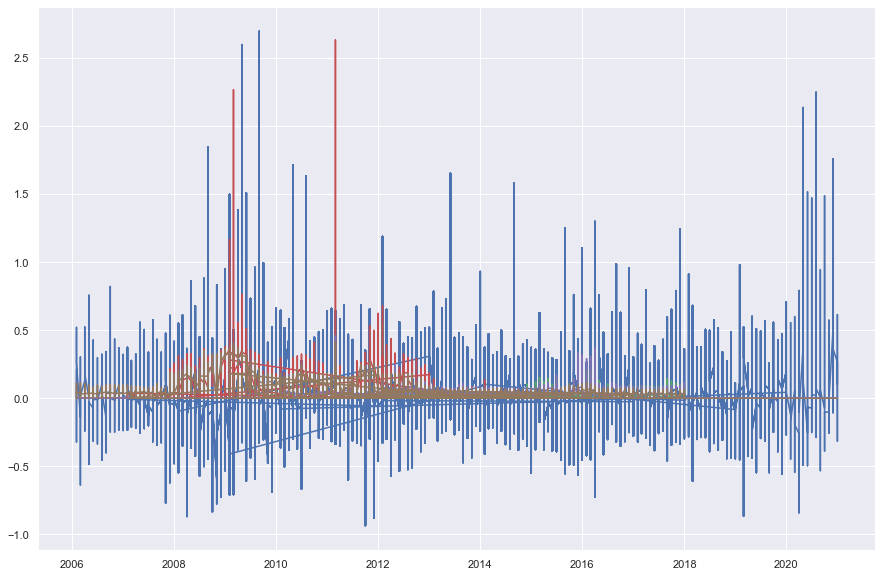

In [298]:
plt.figure(figsize=(15,10))
plt.plot(y)

In [300]:
def cal_oos(preddf):        
    denominator = (preddf['real_y'] ** 2).sum()
    numerator = preddf.apply(lambda x: preddf['real_y'] - x).iloc[:,1:]
    numerator = (numerator ** 2).sum()
        
    roos = 1 - numerator / denominator
    roos.index = roos.index.str.rstrip('_y')
    fig,ax = plt.subplots(figsize = (16,12))
    plt.title('Out-of-sample R2', fontsize = 20)
    ax.bar(x = roos.index, height = roos)
    plt.show()
    return roos

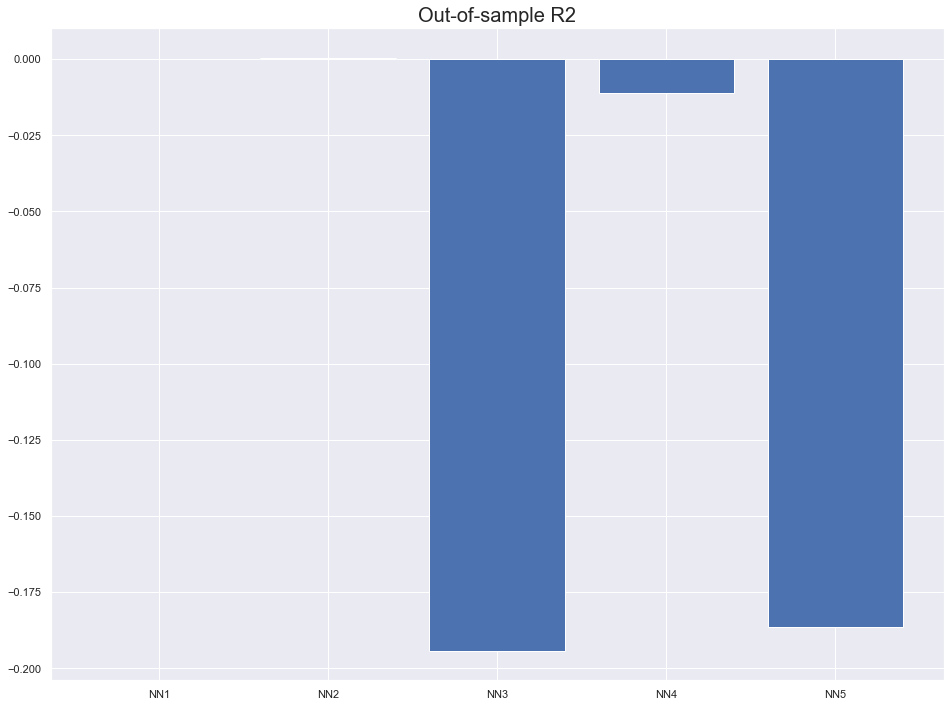

In [301]:
roos = cal_oos(y)

In [302]:
roos

NN1    0.000000
NN2    0.000510
NN3   -0.194206
NN4   -0.011043
NN5   -0.186397
dtype: float64

## 草稿

In [269]:
a = pd.date_range('19720101','19810101',freq='AS-JAN')
a

DatetimeIndex(['1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01',
               '1976-01-01', '1977-01-01', '1978-01-01', '1979-01-01',
               '1980-01-01', '1981-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

In [275]:
for start_date in tqdm(a):
    start_date = a[1] # test
    end_date = start_date + 28 * YearEnd()
    valid_date = end_date + 6 * YearEnd() 
    test_date = valid_date + 6 * YearEnd()

100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 7062.31it/s]


In [276]:
start_date

Timestamp('1973-01-01 00:00:00', freq='AS-JAN')

In [277]:
end_date

Timestamp('2000-12-31 00:00:00', freq='AS-JAN')

In [278]:
valid_date

Timestamp('2006-12-31 00:00:00', freq='AS-JAN')

In [279]:
test_date

Timestamp('2012-12-31 00:00:00', freq='AS-JAN')

In [ ]:
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(testY, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, y_pred)))

plt.plot(mlp_reg.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()


param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid = GridSearchCV(mlp_reg, param_grid, n_jobs= -1, cv=5)
grid.fit(trainX_scaled, trainY)

print(grid.best_params_) 

grid_predictions = grid.predict(testX_scaled) 